## Research Questions: 
1. How much does the deviation of a conjugated form from the root form of a word affect probability of recall when learning a new language?  
3. Does a word being gendered affect probability of recall?
4. Does the part of speech/concrete nature (noun vs not) nature of a word affect probability of recall? 
5. How does time since last study session vary with change in probability of recall (are longer periods of inactivity associated with greater forgetfulness?)




## Data Description:

What are the observations (rows) and the attributes (columns)? : 
   
    Observations are user-word pairs; each observation is associated with a user and the word in their target language that their probability of recalling is based upon. 
    Attributes are as follows: 
        p_recall: describes the probability of the user correctly identifying the word presented to them in their Duolingo practice session. The probability of recall is calculated by dividing the number of times they've correctly guessed the word in the current session by the number of times they've seen the word in the current session. 
        ui_language: describes the language to which the user's user interface is set; this measure is a proxy for the user's native language. 
        learning_language: describes the language that the user is learning on Duolingo; it indicates the language of the word in each observation 
        delta: describes the amount of time between the user's most recent session and the prior session 
        timestamp: indicates the time of the user's most recent session 
        history_seen: indicates the number of times the user has encountered the word in all prior sessions
        history_correct: indicates the number of times that the user has correctly identified the word in all prior sessions
        session_seen: indicates the number of times the user has encountered the word in the most recent session 
        session_correct: indicates the number of times the user has correctly identified the word in the most recent session 
        lexeme_id: is a unique id representation of the word studied by the user
        lexeme_string: represents the word studied in string format; it includes the surface form (i.e. the form of the word that the user is presented with), the word's lemma (the root form of the word), as well as tags to indicate the word's part of speech and gender.
        is_gendered: indicates whether the observed word takes on gendered forms (ex: esa/eso in Spanish) or is neutral
        is_noun: indicates whether the observed word is a noun vs other part of speech
        root_word: describes the word's lemma (the root or indefinite form of the word)
        success_rate_delta: describes the absolute value of the change between historical probability of recall and the probability of recall in the current session
        sim_ratio: uses the Levenshtein ratio (fuzzy matching) to measure how "similar" the surface form is to the lemma
    
    
Why was this dataset created?: 

    This dataset was created to support "Settles and Meeder 2016. A Trainable Spaced Repetition Model for Language 
    Learning." This paper uses the dataset to create a halflife regression model for language learning. 

Who funded the creation of the dataset? : 

    Duolingo, Inc. 

What preprocessing was done, and how did the data come to be in the form that you are using?: 

    Due to the data's size, I processed the original file in chunks of size=500,000, subsetting each chunk to include datapoints on English speakers learning either French or Italian, then created an appended dataset. I checked for any observations with null values (of which I found none). 
    The formats of the data points and column titles are standardized and appear clean, thus no processing was done to change the format of data points or attribute titles. 
    I calculated several additional attributes which I added to the dataset. These new attributes are: is_gendered,is_noun, root_word, success_rate_delta, and sim_ratio.

If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for? :
    
    In order to use Duolingo, users would have had to agree to a Data Privacy agreement giving Duolingo legal right to access the data; it is reasonable to assume people were not actively aware of data collection as it occurred, but they did legally acknowledge awareness of the possibility of data collection. Expectations for the data's usage were most likely not known before usage. 
    
Where can your raw source data be found, if applicable? :

    https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/N8XJME


Data Limitations: 
    
    The ui and learning languages chosen for the dataset exclude data on other ui and learning languages (in particular, there is no data on non-romance languages, thus there is no way to measure recall rates for words in different writing systems, for example). 

    No English speakers' share a target language with any of the other ui_languages. It is thus impossible to compare, for example, the difference in recall rates between Spanish and English speakers learning Italian.

    There is no way to determine the average time between sessions; we can only see the time between the last two consecutive sessions per user. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from fuzzywuzzy import fuzz 
import joypy
import gzip
from translate import Translator



#### Data Load: 

   Load Process: Decompress the file, process into iterable chunks, iterate over data chunks and perform subset, append to new csv file. Performed this step due to overwhelming size of source data file.

In [2]:
file='settles.acl16.learning_traces.13m.csv.gz'

lingo=pd.DataFrame()
with open(file, 'rb') as csvfile:
    lingo=pd.DataFrame()
    
    chunks = pd.read_csv(csvfile,chunksize=500000, compression='gzip',
                   error_bad_lines=False)
    for i,chunk in enumerate(chunks):
        chunk=chunk[(chunk['ui_language']=='en')&((chunk['learning_language']=='it')|(chunk['learning_language']=='fr'))]
       
        print(chunk.head())
        
        mode = 'w' if i == 0 else 'a'
    
        header = i == 0

        chunk.to_csv(
            "duolingo_data.csv",
            index=False,  
            header=header, 
            mode=mode)
        



     p_recall   timestamp   delta user_id learning_language ui_language  \
231       1.0  1362082530  261691  u:hiS4                fr          en   
232       0.5  1362082530  231391  u:hiS4                fr          en   
233       1.0  1362082530  232832  u:hiS4                fr          en   
234       1.0  1362082530  196898  u:hiS4                fr          en   
235       0.0  1362082530  274171  u:hiS4                fr          en   

                            lexeme_id                lexeme_string  \
231  03a546003e03b545a6d419b6620b3749       la/le<det><def><f><sg>   
232  8bd6d060bb604e17c936418f835d87c8     mon/mon<det><pos><m><sg>   
233  1b279bb64bd6eba51ab37e4a61aad0c4    mes/mon<det><pos><mf><pl>   
234  8e6df998cc5c26b86482a3040a5805e2       c'/ce<prn><tn><nt><sg>   
235  3ec6ed7d5a122ac3018def0b4f621b12  nouveau/nouveau<adj><m><sg>   

     history_seen  history_correct  session_seen  session_correct  
231            31               23             1            

         p_recall   timestamp  delta user_id learning_language ui_language  \
3500002       1.0  1362360007    160  u:f2UA                it          en   
3500003       1.0  1362360007    160  u:f2UA                it          en   
3500004       1.0  1362360007    160  u:f2UA                it          en   
3500005       1.0  1362360007    160  u:f2UA                it          en   
3500006       1.0  1362360007    160  u:f2UA                it          en   

                                lexeme_id  \
3500002  e8806f0ea133f740106075fc3b30605b   
3500003  ae7f22f9abe8035306c42fcb30b7d9c6   
3500004  91170b323226b07e5f7f469935bc546f   
3500005  98b3a185ebdc3c67727d2d1f01094ac6   
3500006  9cfb037fb5bf9051645e9c7d5d336c73   

                               lexeme_string  history_seen  history_correct  \
3500002           tu/tu<prn><tn><p2><mf><sg>             9                9   
3500003   mangi/mangiare<vblex><pri><p2><sg>             9                8   
3500004           io/io

         p_recall   timestamp  delta user_id learning_language ui_language  \
6500039  1.000000  1362595482   8522  u:byN7                fr          en   
6500040  1.000000  1362595482   8522  u:byN7                fr          en   
6500041  0.750000  1362595482   8522  u:byN7                fr          en   
6500042  1.000000  1362595482   8522  u:byN7                fr          en   
6500043  0.909091  1362595482   8522  u:byN7                fr          en   

                                lexeme_id                    lexeme_string  \
6500039  74006bc05725c2d7fa3c04e0785513a7           hommes/homme<n><m><pl>   
6500040  ba0a3f9e43bfc46291ffe54c4ff1aa99        enfants/enfant<n><mf><pl>   
6500041  631d297c324518ea97ac01fd2abd6e46         les/le<det><def><mf><pl>   
6500042  23aea42a8b66fbbca4b27c4d93ae385b           femmes/femme<n><f><pl>   
6500043  eeaea9dd7feaad06518e114c325d1308  des/de<pr>+le<det><def><mf><pl>   

         history_seen  history_correct  session_seen  session_

          p_recall   timestamp    delta user_id learning_language ui_language  \
10000007       1.0  1362868774  2948359  u:gEnQ                it          en   
10000008       1.0  1362868774  2670976  u:gEnQ                it          en   
10000009       1.0  1362868774  2949513  u:gEnQ                it          en   
10000010       0.0  1362868774  2960361  u:gEnQ                it          en   
10000011       1.0  1362868774  2950566  u:gEnQ                it          en   

                                 lexeme_id                     lexeme_string  \
10000007  e92b6547f7d453c8549159d5d829ddf1    sui/su<pr>+il<det><def><m><pl>   
10000008  5f4355aad844686519911c41543174bc                       per/per<pr>   
10000009  7afe5be4e22003df093fd609331a703b  sullo/su<pr>+il<det><def><m><sg>   
10000010  6e36fa7c03e819c7622c23cc681f8337                          ad/a<pr>   
10000011  11a42adad4515ac47c5e4708d1c26bb7                         d'/di<pr>   

          history_seen  history_

In [3]:
lingo=pd.read_csv('duolingo_data.csv')
print(lingo.head(),lingo.shape[0])

   p_recall   timestamp   delta user_id learning_language ui_language  \
0       1.0  1362082530  261691  u:hiS4                fr          en   
1       0.5  1362082530  231391  u:hiS4                fr          en   
2       1.0  1362082530  232832  u:hiS4                fr          en   
3       1.0  1362082530  196898  u:hiS4                fr          en   
4       0.0  1362082530  274171  u:hiS4                fr          en   

                          lexeme_id                lexeme_string  \
0  03a546003e03b545a6d419b6620b3749       la/le<det><def><f><sg>   
1  8bd6d060bb604e17c936418f835d87c8     mon/mon<det><pos><m><sg>   
2  1b279bb64bd6eba51ab37e4a61aad0c4    mes/mon<det><pos><mf><pl>   
3  8e6df998cc5c26b86482a3040a5805e2       c'/ce<prn><tn><nt><sg>   
4  3ec6ed7d5a122ac3018def0b4f621b12  nouveau/nouveau<adj><m><sg>   

   history_seen  history_correct  session_seen  session_correct  
0            31               23             1                1  
1            28     

#### Sample data for smaller dataset
Draw random 50,000 rows from each target-language subset to reduce prohibitive size of dataset.

In [4]:
sample_df=pd.DataFrame(columns=list(lingo.columns))

for lang in lingo.learning_language.unique():
    new_df=lingo[lingo.learning_language==lang].sample(50000)
    sample_df=sample_df.append(new_df)
lingo=sample_df

#### Checking for any null entries in the dataset.

In [5]:
null_rows=lingo.isnull()
nulls=null_rows.any(axis=1)
lingo[nulls].p_recall.value_counts()
print("There are {} rows with a null value.".format(lingo[nulls].shape[0]))



There are 0 rows with a null value.


#### Create new variables: 
1. root_word: the non-conjugated form of the word (ex: in Spanish, tengo is the target word, tener is the root word)

2. post: part of speech of the target word

3. is_gendered: whether the target word is a gendered word, and thus requires special gendered conjugations, or not

4. hist_p_recall: the total number of correct guessed before the current session divided by the total number of guesses before the current session

5. success_rate_delta: magnitude of the change in probability of recall between current session and previous sessions

In [6]:
#isolate target word
lingo['root_word'] = lingo.apply(
    lambda row: row.lexeme_string[row.lexeme_string.index('/')+1:row.lexeme_string.index('<')], axis=1)

lingo['pos']=lingo.apply(lambda row: row.lexeme_string[row.lexeme_string.index('<')+1:row.lexeme_string.index('>')],axis=1)

#determine whether target word is gendered
gen_indicator= lingo['lexeme_string'].str.contains('<m>|<f>')
lingo['is_gendered']=gen_indicator

lingo['hist_p_recall']=lingo['history_correct']/lingo['history_seen']

#calculate difference in success rate from most recent session vs historical success rate
lingo['success_rate_delta']=abs(lingo['p_recall']-lingo['hist_p_recall'])


print(lingo.head())



         p_recall   timestamp    delta user_id learning_language ui_language  \
2166743       1.0  1362908564     2751  u:dUt_                fr          en   
2416964       1.0  1363010952    70112  u:h1KG                fr          en   
777538        1.0  1362372121  4188825  u:gtDW                fr          en   
2377831       1.0  1362987335    85952  u:iFIP                fr          en   
2347741       1.0  1362971088       75  u:iqrd                fr          en   

                                lexeme_id  \
2166743  ae8431b7a1e1dddda05fa8020bef985e   
2416964  b1a71481e27138dc37501f2cbde775fc   
777538   5b714a6b291731d4b753c6372cde357a   
2377831  27c57efce52f90deaa1c69be204b54a0   
2347741  5594b03119f7beb09faeab02bda34d19   

                                 lexeme_string history_seen history_correct  \
2166743            quoi/quoi<prn><itg><mf><sp>            4               2   
2416964            es/être<vbser><pri><p2><sg>           19              18   
777538     

#### Create new variable

1. is_noun: indicates whether or not the target word's part of speech is a noun or not


In [8]:
lingo.to_csv(
        "lingo.csv",
        index=False,  
        header=True, 
        mode='w')
lingo=pd.read_csv('lingo.csv')


noun_indicator= lingo['lexeme_string'].str.contains('<n>')
lingo['is_noun']=noun_indicator
lingo.head()



,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,root_word,pos,is_gendered,hist_p_recall,success_rate_delta,is_noun
0,1.0,1362908564,2751,u:dUt_,fr,en,ae8431b7a1e1dddda05fa8020bef985e,quoi/quoi<prn><itg><mf><sp>,4,2,1,1,quoi,prn,False,0.500000,0.500000,False
1,1.0,1363010952,70112,u:h1KG,fr,en,b1a71481e27138dc37501f2cbde775fc,es/être<vbser><pri><p2><sg>,19,18,1,1,être,vbser,False,0.947368,0.052632,False
2,1.0,1362372121,4188825,u:gtDW,fr,en,5b714a6b291731d4b753c6372cde357a,manges/manger<vblex><pri><p2><sg>,2,2,1,1,manger,vblex,False,1.000000,0.000000,False
3,1.0,1362987335,85952,u:iFIP,fr,en,27c57efce52f90deaa1c69be204b54a0,<*sf>/poser<vblex><pri><*pers><*numb>,5,4,1,1,NaN,*sf,False,0.800000,0.200000,False
4,1.0,1362971088,75,u:iqrd,fr,en,5594b03119f7beb09faeab02bda34d19,elle/il<prn><tn><p3><f><sg>,76,74,1,1,il,prn,True,0.973684,0.026316,False


#### Create new variable: 

1. sim_ratio: the Levenshtein ratio of the target word to its root word. Measures how similar the target word looks in comparison to its root.

In [9]:
s=lingo.iloc[1,7]
s2=lingo.iloc[1,12]
print(s)
print(s[:s.index('/')])
print(fuzz.ratio(s[:s.index('/')],s2))
lingo['sim_ratio']=lingo.apply(lambda row: fuzz.ratio(str(row.lexeme_string[:row.lexeme_string.index('/')]),str(row.root_word)),axis=1)


es/être<vbser><pri><p2><sg>
es
33


#### Generate summary statistics for variables of interest

In [10]:
lingo['success_rate_delta']=abs(lingo['success_rate_delta'])
lingo[['p_recall','hist_p_recall','delta','success_rate_delta','sim_ratio']].describe()


,p_recall,hist_p_recall,delta,success_rate_delta,sim_ratio
count,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.00000
mean,0.895838,0.894479,5.267101e+05,0.166924,74.76548
std,0.271265,0.141799,1.673955e+06,0.241942,33.80759
min,0.000000,0.045455,1.000000e+00,0.000000,0.00000
25%,1.000000,0.833333,4.510000e+02,0.000000,50.00000
50%,1.000000,0.956522,6.035050e+04,0.076923,91.00000
75%,1.000000,1.000000,3.480785e+05,0.242424,100.00000
max,1.000000,1.000000,2.660361e+07,1.000000,100.00000


Group data by user, show trends of delta vs success_rate_delta and delta vs p_recall

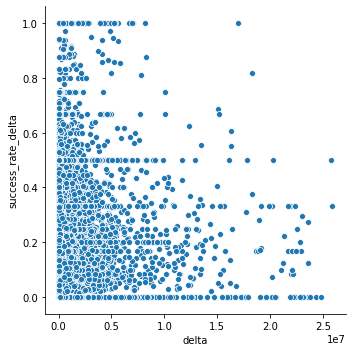

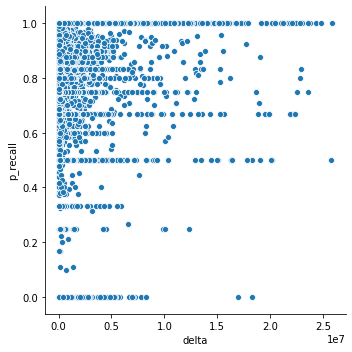

In [11]:
users=lingo.groupby('user_id').mean()
sns.relplot(x='delta',y='success_rate_delta',data=users)
sns.relplot(x='delta',y='p_recall',data=users)

It appears that lower deltas are associated with higher probability of recall, though a linear trend is not present

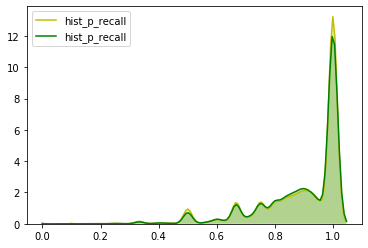

In [12]:
sns.kdeplot(lingo.loc[lingo['is_gendered']==True,'hist_p_recall'],shade=True,color="y")
sns.kdeplot(lingo.loc[lingo['is_gendered']==False,'hist_p_recall'],shade=True,color="g")



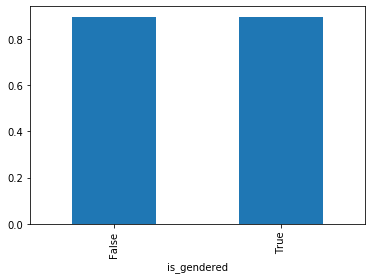

In [13]:
gender_words=lingo.groupby('is_gendered').hist_p_recall.mean().plot(kind='bar')

There does not appear to be any difference in the distribution of historical probability of recall depending on whether the word is gendered or not. 

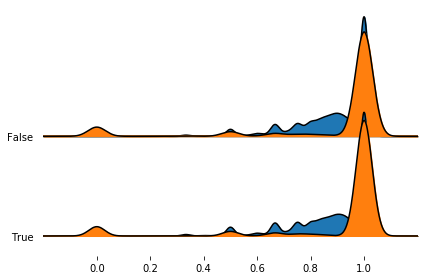

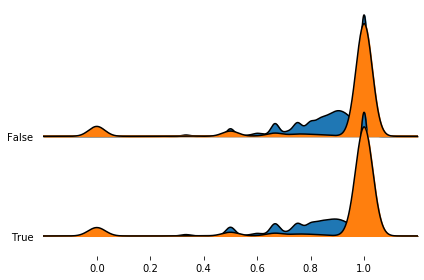

In [14]:

fig,axes=joypy.joyplot(lingo,column=['hist_p_recall','p_recall'],by='is_gendered')
fig,axes=joypy.joyplot(lingo,column=['hist_p_recall','p_recall'],by='is_noun')









It appears that neither the distribution of historical or current probability of recall is affected by the gendering or part of speech of the observed word. 

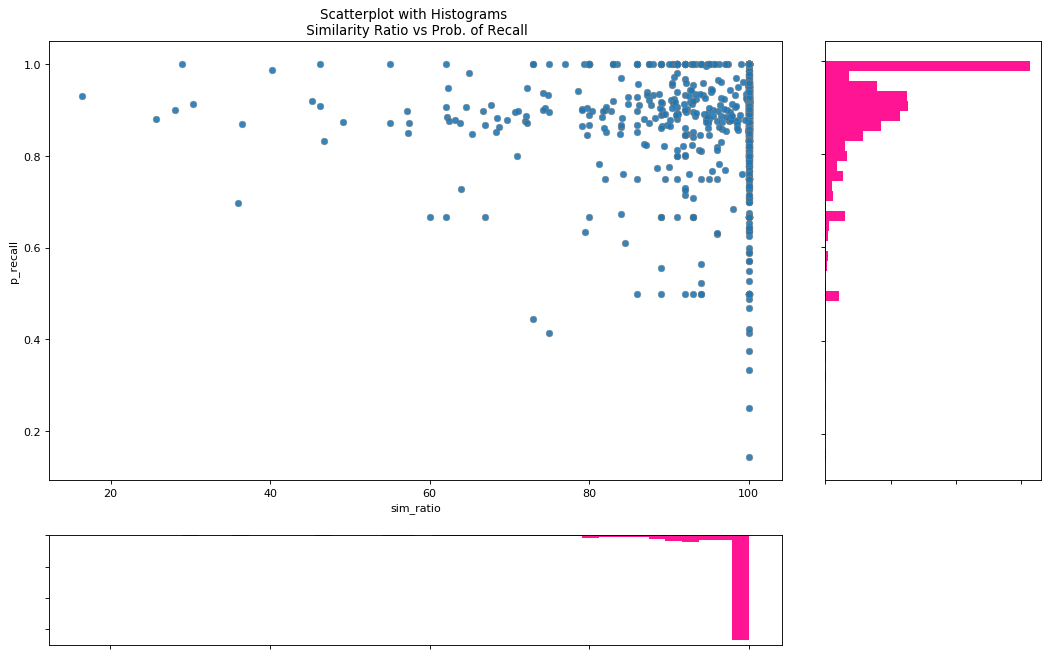

In [15]:
words=lingo.groupby('root_word').mean()
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid=gridspec.GridSpec(4, 4,
                      wspace=0.2, hspace=0.5)
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

# Scatterplot on main ax
ax_main.scatter('sim_ratio', 'hist_p_recall', alpha=.9, data=words, cmap="tab10", edgecolors='gray', linewidths=.5)

# histogram on the right
ax_bottom.hist(words.sim_ratio, 40, histtype='stepfilled', orientation='vertical', color='deeppink')
ax_bottom.invert_yaxis()

# histogram in the bottom
ax_right.hist(words.hist_p_recall, 40, histtype='stepfilled', orientation='horizontal', color='deeppink')
ax_main.set(title='Scatterplot with Histograms \n Similarity Ratio vs Prob. of Recall', xlabel='sim_ratio', ylabel='p_recall')
plt.show()


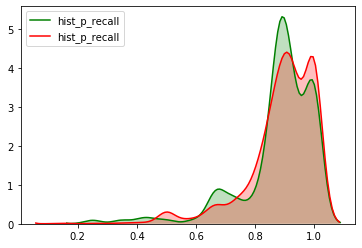

In [16]:
low_sim_words=lingo.loc[lingo['sim_ratio']<=80]
high_sim_words=lingo.loc[lingo['sim_ratio']>80]
low_words=low_sim_words.groupby('root_word').mean()
high_words=high_sim_words.groupby('root_word').mean()
sns.kdeplot(low_words.hist_p_recall,shade=True,color="g")

sns.kdeplot(high_words.hist_p_recall,shade=True,color="r")


It does appear that higher similarity ratios are associated with higher probability of recall. 

In [17]:
foi=['sim_ratio','hist_p_recall','p_recall',]

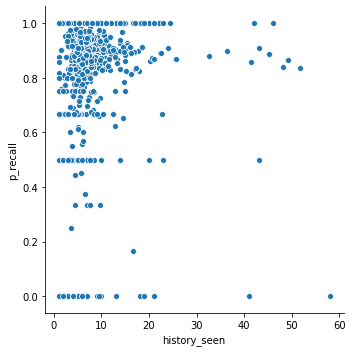

In [19]:

sns.relplot(x='history_seen',y='p_recall',data=words)



#### Create interaction variables for data analysis
1. delta_x_noun: interaction between delta (time elapsed between previous and current session) and whether or not the target word is a noun

2. seen_x_delta: interaction between history_seen ( total number of times learner has seen the target word before current session) and delta

In [21]:
lingo['delta_x_noun']=lingo['delta']*lingo['is_noun']
lingo['seen_x_delta']=lingo['history_seen']*lingo['delta']

lingo['success_rate_delta']=lingo['p_recall']-lingo['hist_p_recall']

In [23]:
lingo.to_csv(
        "prepped_lingo.csv",
        index=False,  
        header=True, 
        mode='w')